In [1]:
import torch
import torch.nn as nn
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import json
import numpy as np
from PIL import ImageDraw
import torch.utils.data as data
from torch.autograd import Variable

In [2]:
class Refine(nn.Module):
    def __init__(self, input_nc, output_nc=3):
        super(Refine, self).__init__()
        nl = nn.InstanceNorm2d
        self.conv1 = nn.Sequential(*[nn.Conv2d(input_nc, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU(),
                                     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU()])
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Sequential(*[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU(),
                                     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU()])
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Sequential(*[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU(),
                                     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU()])
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv4 = nn.Sequential(*[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU(),
                                     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU()])
        self.drop4 = nn.Dropout(0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv5 = nn.Sequential(*[nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1), nl(1024), nn.ReLU(),
                                     nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1), nl(1024), nn.ReLU()])
        self.drop5 = nn.Dropout(0.5)
        self.up6 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1), nl(512),
              nn.ReLU()])
        self.conv6 = nn.Sequential(*[nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU(),
                                     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU()])
        self.up7 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), nl(256),
              nn.ReLU()])
        self.conv7 = nn.Sequential(*[nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU(),
                                     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU()])

        self.up8 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nl(128),
              nn.ReLU()])
        self.conv8 = nn.Sequential(*[nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU(),
                                     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU()])

        self.up9 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), nl(64),
              nn.ReLU()])
        self.conv9 = nn.Sequential(*[nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU(),
                                     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU(),
                                     nn.Conv2d(64, output_nc, kernel_size=3, stride=1, padding=1)
                                     ])

    def refine(self, input):
        conv1 = self.conv1(input)
        pool1 = self.pool1(conv1)
        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)
        conv4 = self.conv4(pool3)
        drop4 = self.drop4(conv4)
        pool4 = self.pool4(drop4)
        conv5 = self.conv5(pool4)
        drop5 = self.drop5(conv5)
        up6 = self.up6(drop5)
        conv6 = self.conv6(torch.cat([drop4, up6], 1))
        up7 = self.up7(conv6)
        conv7 = self.conv7(torch.cat([conv3, up7], 1))
        up8 = self.up8(conv7)
        conv8 = self.conv8(torch.cat([conv2, up8], 1))
        up9 = self.up9(conv8)
        conv9 = self.conv9(torch.cat([conv1, up9], 1))
        return conv9

In [3]:
G2 = Refine(19+18, 1)
G2.load_state_dict(torch.load('../label2city/latest_net_G2.pth'))
G2.cuda(0)

Refine(
  (conv1): Sequential(
    (0): Conv2d(37, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
 

In [4]:
import random
import os.path as osp

def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    f = dir.split('/')[-1].split('_')[-1]
    print (dir, f)
    dirs= os.listdir(dir)
    for img in dirs:

        path = os.path.join(dir, img)
        #print(path)
        images.append(path)
    return images

def get_params(size):
    w, h = size
    new_h = h
    new_w = w
    x = random.randint(0, np.maximum(0, new_w - 512))
    y = random.randint(0, np.maximum(0, new_h - 512))
    flip = 0
    return {'crop_pos': (x, y), 'flip': flip}

def get_transform(normalize=True):
    transform_list = []
    transform_list += [transforms.ToTensor()]
    if normalize:
        transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

class AlignedDataset(data.Dataset):
    def __init__(self, phase, dataroot):
        super(AlignedDataset, self).__init__()
        self.diction={}
        ### input A (label maps)
        dir_A = '_label'
        self.dir_A = os.path.join(dataroot, phase + dir_A)
        self.A_paths = sorted(make_dataset(self.dir_A))
        self.AR_paths = make_dataset(self.dir_A)

        self.fine_height=256
        self.fine_width=192
        self.radius=5

        dir_B = '_img'
        self.dir_B = os.path.join(dataroot, phase + dir_B)  
        self.B_paths = sorted(make_dataset(self.dir_B))
        self.BR_paths = sorted(make_dataset(self.dir_B))
        self.dataset_size = len(self.A_paths)
        self.build_index(self.B_paths)
        dir_E = '_edge'
        self.dir_E = os.path.join(dataroot, phase + dir_E)
        self.E_paths = sorted(make_dataset(self.dir_E))
        self.ER_paths = make_dataset(self.dir_E)
        dir_M = '_mask'
        self.dir_M = os.path.join(dataroot, phase + dir_M)
        self.M_paths = sorted(make_dataset(self.dir_M))
        self.MR_paths = make_dataset(self.dir_M)
        dir_C = '_color'
        self.dir_C = os.path.join(dataroot, phase + dir_C)
        self.C_paths = sorted(make_dataset(self.dir_C))
        self.CR_paths = make_dataset(self.dir_C)
      
    def random_sample(self,item):
        name = item.split('/')[-1]
        name = name.split('-')[0]
        lst=self.diction[name]
        new_lst=[]
        for dir in lst:
            if dir != item:
                new_lst.append(dir)
        return new_lst[np.random.randint(len(new_lst))]
    def build_index(self,dirs):
        #ipdb.set_trace()
        for k,dir in enumerate(dirs):
            name=dir.split('/')[-1]
            name=name.split('-')[0]

            # print(name)
            for k,d in enumerate(dirs[max(k-20,0):k+20]):
                if name in d:
                    if name not in self.diction.keys():
                        self.diction[name]=[]
                        self.diction[name].append(d)
                    else:
                        self.diction[name].append(d)


    def __getitem__(self, index):        
        train_mask=9600
        test=index#np.random.randint(10000)
        A_path = self.A_paths[index]
        AR_path = self.AR_paths[index]
        A = Image.open(A_path).convert('L')
        AR = Image.open(AR_path).convert('L')
        print(A.size)
        params = get_params(A.size)
        transform_A = get_transform(normalize=False)
        A_tensor = transform_A(A) * 255.0
        AR_tensor = transform_A(AR) * 255.0
        B_tensor = inst_tensor = feat_tensor = 0
        ### input B (real images)
        B_path = self.B_paths[index]
        BR_path = self.BR_paths[index]
        B = Image.open(B_path).convert('RGB')
        BR = Image.open(BR_path).convert('RGB')
        transform_B = get_transform()      
        B_tensor = transform_B(B)
        BR_tensor = transform_B(BR)
        M_path = self.M_paths[np.random.randint(1)]
        MR_path =self.MR_paths[np.random.randint(1)]
        M = Image.open(M_path).convert('L')
        MR = Image.open(MR_path).convert('L')
        M_tensor = transform_A(MR)
        MC_path = B_path#self.MC_paths[1]
        MCR_path = B_path#self.MCR_paths[1]
        MCR = Image.open(MCR_path).convert('L')
        MC_tensor = transform_A(MCR)
        C_path = self.C_paths[test]
        C = Image.open(C_path).convert('RGB')
        C_tensor = transform_B(C)
        E_path = self.E_paths[test]
        E = Image.open(E_path).convert('L')
        E_tensor = transform_A(E)
        pose_name =B_path.replace('.png', '_keypoints.json').replace('.jpg','_keypoints.json').replace('test_img','test_pose')
        with open(osp.join(pose_name), 'r') as f:
            pose_label = json.load(f)
            try:
                pose_data = pose_label['people'][0]['pose_keypoints']
            except IndexError:
                pose_data = [0 for i in range(54)]
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1,3))

        point_num = pose_data.shape[0]
        pose_map = torch.zeros(point_num, self.fine_height, self.fine_width)
        r = self.radius
        im_pose = Image.new('L', (self.fine_width, self.fine_height))
        pose_draw = ImageDraw.Draw(im_pose)
        for i in range(point_num):
            one_map = Image.new('L', (self.fine_width, self.fine_height))
            draw = ImageDraw.Draw(one_map)
            pointx = pose_data[i,0]
            pointy = pose_data[i,1]
            if pointx > 1 and pointy > 1:
                draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
                pose_draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
            one_map = transform_B(one_map.convert('RGB'))
            pose_map[i] = one_map[0]
        P_tensor=pose_map
        input_dict = { 'label': A_tensor, 'label_ref': AR_tensor, 'image': B_tensor, 'image_ref': BR_tensor, 'path': A_path, 'path_ref': AR_path,
                       'edge': E_tensor,'color': C_tensor, 'mask': M_tensor, 'colormask': MC_tensor,'pose':P_tensor}
        return input_dict

    def __len__(self):
        return len(self.A_paths)

    def name(self):
        return 'AlignedDataset'

In [5]:
data_loader = AlignedDataset('test','../../longshortV2/test')
dataloader = torch.utils.data.DataLoader(
            data_loader,
            batch_size=1)

../../longshortV2/test\test_label label
../../longshortV2/test\test_label label
../../longshortV2/test\test_img img
../../longshortV2/test\test_img img
../../longshortV2/test\test_edge edge
../../longshortV2/test\test_edge edge
../../longshortV2/test\test_mask mask
../../longshortV2/test\test_mask mask
../../longshortV2/test\test_color color
../../longshortV2/test\test_color color


In [6]:
data_loader.name()

'AlignedDataset'

In [7]:
len(data_loader)

1

In [8]:
def changearm(old_label):
    label=old_label
    arm1=torch.FloatTensor((data['label'].cpu().numpy()==11).astype(np.int))
    arm2=torch.FloatTensor((data['label'].cpu().numpy()==13).astype(np.int))
    noise=torch.FloatTensor((data['label'].cpu().numpy()==7).astype(np.int))
    label=label*(1-arm1)+arm1*4
    label=label*(1-arm2)+arm2*4
    label=label*(1-noise)+noise*4
    return label

for i, data in enumerate(dataloader, start=0):
    t_mask=torch.FloatTensor((data['label'].cpu().numpy()==7).astype(np.float))
    data['label']=data['label']*(1-t_mask)+t_mask*4
    mask_clothes=torch.FloatTensor((data['label'].cpu().numpy()==4).astype(np.int))
    mask_fore=torch.FloatTensor((data['label'].cpu().numpy()>0).astype(np.int))
    img_fore=data['image']*mask_fore
    img_fore_wc=img_fore*mask_fore
    all_clothes_label=changearm(data['label'])


(192, 256)


<ipython-input-8-12b679d31472>:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t_mask=torch.FloatTensor((data['label'].cpu().numpy()==7).astype(np.float))
<ipython-input-8-12b679d31472>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

In [9]:
t_mask=torch.FloatTensor((data['label'].cpu().numpy()==7).astype(np.float))
data['label']=data['label']*(1-t_mask)+t_mask*4
mask_clothes=torch.FloatTensor((data['label'].cpu().numpy()==4).astype(np.int))
mask_fore=torch.FloatTensor((data['label'].cpu().numpy()>0).astype(np.int))
img_fore=data['image']*mask_fore
img_fore_wc=img_fore*mask_fore
all_clothes_label=changearm(data['label'])

<ipython-input-9-850f6b52291c>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t_mask=torch.FloatTensor((data['label'].cpu().numpy()==7).astype(np.float))
<ipython-input-9-850f6b52291c>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

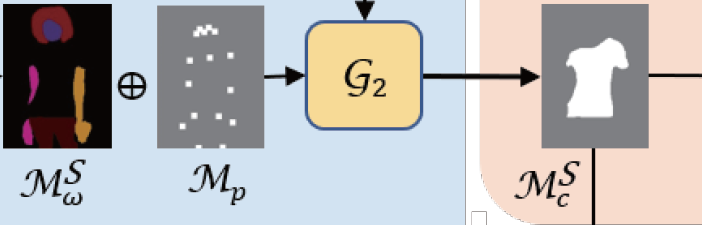

In [10]:
sgm = torch.load('sgm.pt', map_location=torch.device('cuda'))

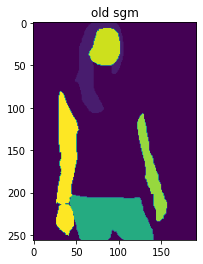

In [11]:
figure = plt.figure()
figure.add_subplot(1,1, 1).set_title('old sgm')
plt.imshow((sgm[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
plt.show(block=True)

In [12]:
def encode_input(label_map, clothes_mask, all_clothes_label):

    size = label_map.size()
    oneHot_size = (size[0], 14, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)

    masked_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    masked_label = masked_label.scatter_(1, (label_map * (1 - clothes_mask)).data.long().cuda(), 1.0)

    c_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    c_label = c_label.scatter_(1, all_clothes_label.data.long().cuda(), 1.0)

    input_label = Variable(input_label)

    return input_label, masked_label, c_label

mask_clothes = torch.FloatTensor((data['label'].cpu().numpy() == 4).astype(np.int))
in_label = Variable(data['label'].cuda())
in_mask_clothes = Variable(mask_clothes.cuda())
all_clothes_label = changearm(data['label'])
in_all_clothes_label = Variable(all_clothes_label.cuda())
input_label, masked_label, all_clothes_label = encode_input(in_label, in_mask_clothes, in_all_clothes_label)

<ipython-input-12-b30bd127167d>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_clothes = torch.FloatTensor((data['label'].cpu().numpy() == 4).astype(np.int))
<ipython-input-8-12b679d31472>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additi

## G2 input



In [13]:
edge = Variable(data['edge'].cuda())
edge = torch.FloatTensor((edge.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
clothes = Variable(data['color'].cuda())
clothes = clothes*edge
pose = Variable(data['pose'].cuda())

<ipython-input-13-e24d0e73c09f>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  edge = torch.FloatTensor((edge.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()


In [14]:
pose.size()

torch.Size([1, 18, 256, 192])

TypeError: Invalid shape (256, 192, 18) for image data

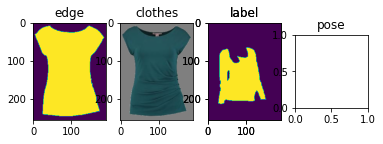

In [15]:
figure = plt.figure()
figure.add_subplot(1,4, 1).set_title('edge')
plt.imshow((edge[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
figure.add_subplot(1,4, 2).set_title('clothes')
plt.imshow((clothes[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
figure.add_subplot(1,4, 3).set_title('label')
plt.imshow((in_mask_clothes[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
figure.add_subplot(1,4, 3).set_title('label')
plt.imshow((in_mask_clothes[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
figure.add_subplot(1,4, 4).set_title('pose')
plt.imshow((pose[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
plt.show(block=True)

In [16]:
import cv2

def gen_noise(shape):
    noise = np.zeros(shape, dtype=np.uint8)
    ### noise
    noise = cv2.randn(noise, 0, 255)
    noise = np.asarray(noise / 255, dtype=np.uint8)
    noise = torch.tensor(noise, dtype=torch.float32)
    return noise.cuda()

In [17]:
shape = edge.shape

G2_in = torch.cat([edge,clothes,masked_label,pose, gen_noise(shape)],1)

fake_cl=G2.refine(G2_in)

sigmoid = nn.Sigmoid()
fake_cl = sigmoid(fake_cl)

In [18]:
fake_cl.size()

torch.Size([1, 1, 256, 192])

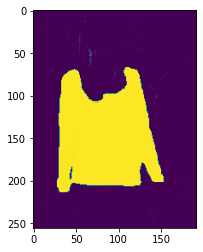

In [19]:
plt.imshow((fake_cl[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)


# Spatial Transformation Network (STN)

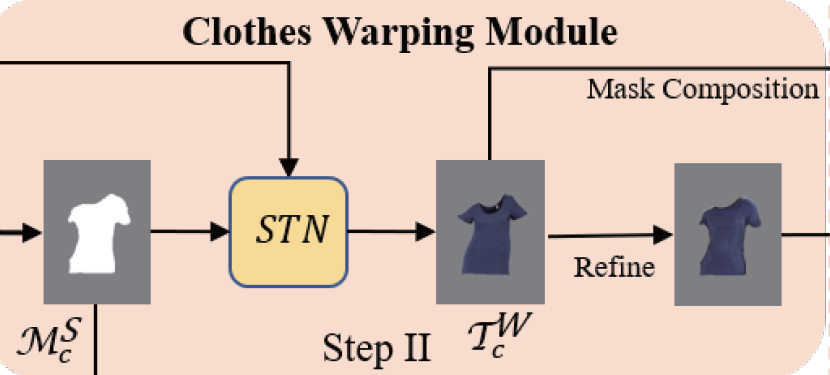

In [32]:
class CNN(nn.Module):
    def __init__(self, num_output, input_nc=5, ngf=8, n_layers=5, norm_layer=nn.InstanceNorm2d, use_dropout=False):
        super(CNN, self).__init__()
        downconv = nn.Conv2d(5, ngf, kernel_size=4, stride=2, padding=1)
        model = [downconv, nn.ReLU(True), norm_layer(ngf)]
        for i in range(n_layers):
            in_ngf = 2 ** i * ngf if 2 ** i * ngf < 1024 else 1024
            out_ngf = 2 ** (i + 1) * ngf if 2 ** i * ngf < 1024 else 1024
            downconv = nn.Conv2d(in_ngf, out_ngf, kernel_size=4, stride=2, padding=1)
            model += [downconv, norm_layer(out_ngf), nn.ReLU(True)]
        model += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                  norm_layer(64), nn.ReLU(True)]
        model += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                  norm_layer(64), nn.ReLU(True)]
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.model = nn.Sequential(*model)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, num_output)
    def forward(self, x):
        x = self.model(x)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

class BoundedGridLocNet(nn.Module):

    def __init__(self, grid_height, grid_width, target_control_points):
        super(BoundedGridLocNet, self).__init__()
        self.cnn = CNN(grid_height * grid_width * 2)

        bias = torch.from_numpy(np.arctanh(target_control_points.numpy()))
        bias = bias.view(-1)
        self.cnn.fc2.bias.data.copy_(bias)
        self.cnn.fc2.weight.data.zero_()

    def forward(self, x):
        batch_size = x.size(0)
        points = F.tanh(self.cnn(x))
        #ipdb.set_trace()
        coor=points.view(batch_size, -1, 2)
        row=self.get_row(coor,5)
        col=self.get_col(coor,5)
        rg_loss = sum(self.grad_row(coor, 5))
        cg_loss = sum(self.grad_col(coor, 5))
        rg_loss = torch.max(rg_loss,torch.tensor(0.02).cuda())
        cg_loss = torch.max(cg_loss,torch.tensor(0.02).cuda())
        rx,ry,cx,cy=torch.tensor(0.08).cuda(),torch.tensor(0.08).cuda()\
            ,torch.tensor(0.08).cuda(),torch.tensor(0.08).cuda()
        row_x,row_y=row[:,:,0],row[:,:,1]
        col_x,col_y=col[:,:,0],col[:,:,1]
        rx_loss=torch.max(rx,row_x).mean()
        ry_loss=torch.max(ry,row_y).mean()
        cx_loss=torch.max(cx,col_x).mean()
        cy_loss=torch.max(cy,col_y).mean()
        

        return  coor,rx_loss,ry_loss,cx_loss,cy_loss,rg_loss,cg_loss

    def get_row(self,coor,num):
        sec_dic=[]
        for j in range(num):
            sum=0
            buffer=0
            flag=False
            max=-1
            for i in range(num-1):
                differ=(coor[:,j*num+i+1,:]-coor[:,j*num+i,:])**2
                if not flag:
                    second_dif=0
                    flag=True
                else:
                    second_dif=torch.abs(differ-buffer)
                    sec_dic.append(second_dif)

                buffer=differ
                sum+=second_dif
        return torch.stack(sec_dic,dim=1)

    def get_col(self,coor,num):
        sec_dic=[]
        for i in range(num):
            sum = 0
            buffer = 0
            flag = False
            max = -1
            for j in range(num - 1):
                differ = (coor[:, (j+1) * num + i , :] - coor[:, j * num + i, :]) ** 2
                if not flag:
                    second_dif = 0
                    flag = True
                else:
                    second_dif = torch.abs(differ-buffer)
                    sec_dic.append(second_dif)
                buffer = differ
                sum += second_dif
        return torch.stack(sec_dic,dim=1)

    def grad_row(self, coor, num):
        sec_term = []
        for j in range(num):
            for i in range(1, num - 1):
                x0, y0 = coor[:, j * num + i - 1, :][0]
                x1, y1 = coor[:, j * num + i + 0, :][0]
                x2, y2 = coor[:, j * num + i + 1, :][0]
                grad = torch.abs((y1 - y0) * (x1 - x2) - (y1 - y2) * (x1 - x0))
                sec_term.append(grad)
        return sec_term

    def grad_col(self, coor, num):
        sec_term = []
        for i in range(num):
            for j in range(1, num - 1):
                x0, y0 = coor[:, (j - 1) * num + i, :][0]
                x1, y1 = coor[:, j * num + i, :][0]
                x2, y2 = coor[:, (j + 1) * num + i, :][0]
                grad = torch.abs((y1 - y0) * (x1 - x2) - (y1 - y2) * (x1 - x0))
                sec_term.append(grad)
        return sec_term

class UnBoundedGridLocNet(nn.Module):

    def __init__(self, grid_height, grid_width, target_control_points):
        super(UnBoundedGridLocNet, self).__init__()
        self.cnn = CNN(grid_height * grid_width * 2)

        bias = target_control_points.view(-1)
        self.cnn.fc2.bias.data.copy_(bias)
        self.cnn.fc2.weight.data.zero_()

    def forward(self, x):
        batch_size = x.size(0)
        points = self.cnn(x)
        return points.view(batch_size, -1, 2)

In [33]:
from tps_grid_gen import TPSGridGen

import itertools

class STNNet(nn.Module):
    def __init__(self):
        super(STNNet, self).__init__()
        range = 0.9
        r1 = range
        r2 = range
        grid_size_h = 5
        grid_size_w = 5

        assert r1 < 1 and r2 < 1 
        target_control_points = torch.Tensor(list(itertools.product(
            np.arange(-r1, r1 + 0.00001, 2.0 * r1 / (grid_size_h - 1)),
            np.arange(-r2, r2 + 0.00001, 2.0 * r2 / (grid_size_w - 1)),
        )))
        Y, X = target_control_points.split(1, dim=1)
        target_control_points = torch.cat([X, Y], dim=1)
        # self.get_row(target_control_points,5)
        GridLocNet = {
            'unbounded_stn': UnBoundedGridLocNet,
            'bounded_stn': BoundedGridLocNet,
        }['bounded_stn']
        self.loc_net = GridLocNet(grid_size_h, grid_size_w, target_control_points)

        self.tps = TPSGridGen(256, 192, target_control_points)

    def get_row(self, coor, num):
        for j in range(num):
            sum = 0
            buffer = 0
            flag = False
            max = -1
            for i in range(num - 1):
                differ = (coor[j * num + i + 1, :] - coor[j * num + i, :]) ** 2
                if not flag:
                    second_dif = 0
                    flag = True
                else:
                    second_dif = torch.abs(differ - buffer)

                buffer = differ
                sum += second_dif
            print(sum / num)
    def get_col(self,coor,num):
        for i in range(num):
            sum = 0
            buffer = 0
            flag = False
            max = -1
            for j in range(num - 1):
                differ = (coor[ (j + 1) * num + i, :] - coor[j * num + i, :]) ** 2
                if not flag:
                    second_dif = 0
                    flag = True
                else:
                    second_dif = torch.abs(differ-buffer)

                buffer = differ
                sum += second_dif
            print(sum)
    def forward(self, x, reference, mask):
        batch_size = x.size(0)
        source_control_points,rx,ry,cx,cy,rg,cg = self.loc_net(reference)
        source_control_points=(source_control_points)
        print('control points',source_control_points.shape)
        source_coordinate = self.tps(source_control_points)
        grid = source_coordinate.view(batch_size, 256, 192, 2)
        print('grid size',grid.shape)
        transformed_x = grid_sample(x, grid, canvas=0)
        warped_mask = grid_sample(mask, grid, canvas=0)
        return transformed_x, warped_mask,rx,ry,cx,cy,rg,cg


class UnetMask(nn.Module):
    def __init__(self, input_nc, output_nc=3):
        super(UnetMask, self).__init__()
        self.stn = STNNet()
        nl = nn.InstanceNorm2d
        self.conv1 = nn.Sequential(*[nn.Conv2d(input_nc, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU(),
                                     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU()])
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Sequential(*[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU(),
                                     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU()])
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Sequential(*[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU(),
                                     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU()])
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv4 = nn.Sequential(*[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU(),
                                     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU()])
        self.drop4 = nn.Dropout(0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv5 = nn.Sequential(*[nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1), nl(1024), nn.ReLU(),
                                     nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1), nl(1024), nn.ReLU()])
        self.drop5 = nn.Dropout(0.5)

        self.up6 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1), nl(512),
              nn.ReLU()])

        self.conv6 = nn.Sequential(*[nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU(),
                                     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU()])
        self.up7 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), nl(256),
              nn.ReLU()])
        self.conv7 = nn.Sequential(*[nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU(),
                                     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU()])

        self.up8 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nl(128),
              nn.ReLU()])

        self.conv8 = nn.Sequential(*[nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU(),
                                     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU()])

        self.up9 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), nl(64),
              nn.ReLU()])

        self.conv9 = nn.Sequential(*[nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU(),
                                     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU(),
                                     nn.Conv2d(64, output_nc, kernel_size=3, stride=1, padding=1)
                                     ])

    def forward(self, input, refer, mask):
        input, warped_mask,rx,ry,cx,cy,rg,cg = self.stn(input, torch.cat([mask, refer, input], 1), mask)
        #ipdb.set_trace()# print(input.shape)

        conv1 = self.conv1(torch.cat([refer.detach(), input.detach()], 1))
        pool1 = self.pool1(conv1)

        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)

        conv4 = self.conv4(pool3)
        drop4 = self.drop4(conv4)
        pool4 = self.pool4(drop4)

        conv5 = self.conv5(pool4)
        drop5 = self.drop5(conv5)

        up6 = self.up6(drop5)
        conv6 = self.conv6(torch.cat([drop4, up6], 1))

        up7 = self.up7(conv6)
        conv7 = self.conv7(torch.cat([conv3, up7], 1))

        up8 = self.up8(conv7)
        conv8 = self.conv8(torch.cat([conv2, up8], 1))

        up9 = self.up9(conv8)
        conv9 = self.conv9(torch.cat([conv1, up9], 1))
        return conv9, input, warped_mask,rx,ry,cx,cy,rg,cg


In [36]:
Unet = UnetMask(4) 
Unet.cuda(0)
Unet.load_state_dict(torch.load('../label2city/latest_net_U.pth'))

RuntimeError: Error(s) in loading state_dict for UnetMask:
	size mismatch for conv9.6.weight: copying a param with shape torch.Size([4, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([3, 64, 3, 3]).
	size mismatch for conv9.6.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([3]).

In [ ]:
fake_c, warped, warped_mask,rx,ry,cx,cy,rg,cg = self.Unet(clothes, clothes_mask,pre_clothes_mask)
